# **PART 1**

**Install pycbc**

In [1]:
import sys
!{sys.executable} -m pip install lalsuite pycbc


**List of approximants**

In [2]:
from pycbc.waveform import td_approximants, fd_approximants

# List of td approximants that are currently available
print(td_approximants())

['TaylorT1', 'TaylorT2', 'TaylorT3', 'SpinTaylorT1', 'SpinTaylorT4', 'SpinTaylorT5', 'PhenSpinTaylor', 'PhenSpinTaylorRD', 'EOBNRv2', 'EOBNRv2HM', 'TEOBResum_ROM', 'SEOBNRv1', 'SEOBNRv2', 'SEOBNRv2_opt', 'SEOBNRv3', 'SEOBNRv3_pert', 'SEOBNRv3_opt', 'SEOBNRv3_opt_rk4', 'SEOBNRv4', 'SEOBNRv4_opt', 'SEOBNRv4P', 'SEOBNRv4PHM', 'SEOBNRv2T', 'SEOBNRv4T', 'SEOBNRv4_ROM_NRTidalv2', 'SEOBNRv4_ROM_NRTidalv2_NSBH', 'HGimri', 'IMRPhenomA', 'IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'IMRPhenomD_NRTidalv2', 'IMRPhenomNSBH', 'IMRPhenomHM', 'IMRPhenomPv2', 'IMRPhenomPv2_NRTidal', 'IMRPhenomPv2_NRTidalv2', 'TaylorEt', 'TaylorT4', 'EccentricTD', 'SpinDominatedWf', 'NR_hdf5', 'NRSur7dq2', 'NRSur7dq4', 'SEOBNRv4HM', 'NRHybSur3dq8', 'IMRPhenomXAS', 'IMRPhenomXHM', 'IMRPhenomPv3', 'IMRPhenomPv3HM', 'IMRPhenomXP', 'IMRPhenomXPHM', 'TEOBResumS', 'IMRPhenomT', 'IMRPhenomTHM', 'TaylorF2', 'SEOBNRv1_ROM_EffectiveSpin', 'SEOBNRv1_ROM_DoubleSpin', 'SEOBNRv2_ROM_EffectiveSpin', 'SEOBNRv2_ROM_DoubleSpin', 'EOBNRv2_RO

**Load the dataset**

In [3]:
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

File ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.

File ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.



**Load the strain data**

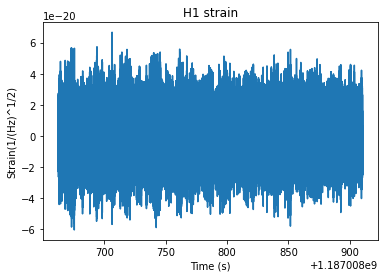

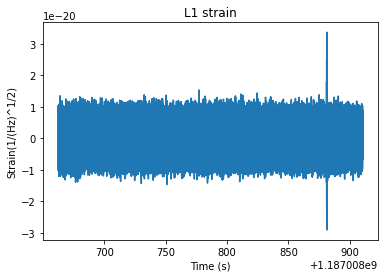

In [4]:
import pylab
from pycbc.catalog import Merger
from pycbc.frame import read_frame
from pycbc.filter import highpass
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['H1', 'L1']:
 ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
 '{}:LOSC-STRAIN'.format(ifo),
 start_time=merger.time - 224,
 end_time=merger.time + 32,
 check_integrity=False)
 strain[ifo] = highpass(ts, 15)
 strain[ifo] = strain[ifo].crop(4, 4)
 stilde[ifo] = strain[ifo].to_frequencyseries()
#Plot strains
pylab.plot(strain['H1'].sample_times, strain['H1'])
pylab.xlabel('Time (s)')
pylab.ylabel('Strain(1/(Hz)^1/2)')
pylab.title('H1 strain')
pylab.show()
pylab.plot(strain['L1'].sample_times, strain['L1'])
pylab.xlabel('Time (s)')
pylab.ylabel('Strain(1/(Hz)^1/2)')
pylab.title('L1 strain')
pylab.show()

**Data Analysis**

Text(0, 0.5, 'Strain')

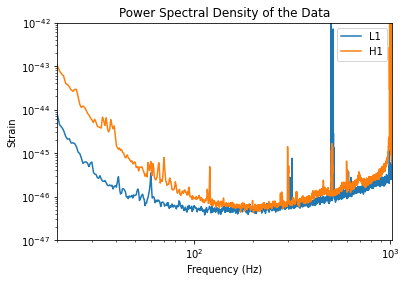

In [5]:
import pycbc.psd
from pycbc.psd import interpolate

psds = {}
for ifo in ['L1', 'H1']:

    delta_t = strain[ifo].delta_t
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2)
    psds[ifo]  = pycbc.psd.welch(strain[ifo],
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)

    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-42)
pylab.legend()
pylab.title('Power Spectral Density of the Data')
pylab.xlabel('Frequency (Hz)')
pylab.ylabel('Strain')

In [6]:
#delta_f for the psd data itself
psds[ifo].delta_f

0.004032258064516129

**Signal-to-Noise**

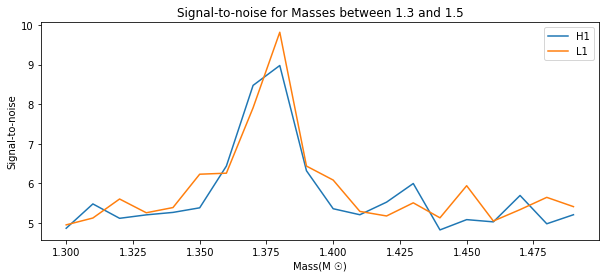

In [7]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
import numpy

mass1 = numpy.arange(1.3,1.5,.01) #mass range between 1.3 to 1.5 Solar mass
mass2 = mass1

hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {}
ifo = 'H1'
Snr_list = []
for i in range(len(mass1)):
 
    m = mass1[i]
    hp, hc = get_fd_waveform(approximant="TaylorF2",
                     mass1=m,
                     mass2=m,
                     delta_f=stilde[ifo].delta_f,
                     f_lower=20.0)

    # Resize the vector to match data
    hp.resize(len(stilde[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, stilde[ifo],
                     psd=psds[ifo], low_frequency_cutoff=20.0)

    # Remove time corrupted by the template filter
    snr_H1 = snr.crop(4 + 4, 4)

    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list

ifo = 'L1'
Snr_list = []
for i in range(len(mass1)):
 
    m = mass1[i] 
    hp, hc = get_fd_waveform(approximant="TaylorF2",
                     mass1=m,
                     mass2=m,
                     delta_f=stilde[ifo].delta_f,
                     f_lower=20.0)

    hp.resize(len(stilde[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, stilde[ifo],
                     psd=psds[ifo], low_frequency_cutoff=20.0)

    snr_H1 = snr.crop(4 + 4, 4)

    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list

pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs['H1'], label= 'H1')
pylab.plot(mass1, snrs['L1'], label= 'L1')
pylab.legend(['H1','L1'])
pylab.title('Signal-to-noise for Masses between 1.3 and 1.5')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Mass(M ☉)')
pylab.show()

**Find out best mass**

In [8]:
masses = numpy.arange(1, 3, .01)
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = []
for m in masses:
 hp, hc = get_fd_waveform(approximant="TaylorF2",
 mass1=m, mass2=m,
 f_lower=20, delta_f=stilde[ifo].delta_f)
 hp.resize(len(stilde[ifo]))
# Matched filter the data and find the peak
 max_snr, max_time = {}, {}
 for ifo in ['L1', 'H1']:
  snr = matched_filter(hp, stilde[ifo], psd=psds[ifo],
  low_frequency_cutoff=20.0)
# The complex SNR at the peak
  snr = snr.time_slice(merger.time - 1, merger.time + 1)
  _, idx = snr.abs_max_loc()
  max_snr[ifo] = snr[idx]
# The time of the peak
  max_time[ifo] = float(idx) / snr.sample_rate + snr.start_time
 network_snr = (abs(numpy.array(list(max_snr.values()))) ** 2.0).sum()** 0.5
 snrs.append(max_snr)
# Keep track of only the loudest peak
 if network_snr > nsnr:
  tmax, hmax, mmax, smax = max_time, hp, m, max_snr
  nsnr = network_snr
print("We found the best Mass1=Mass2 was %2.2f solar masses (detectorframe)" % mmax)


We found the best Mass1=Mass2 was 1.38 solar masses (detectorframe)


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


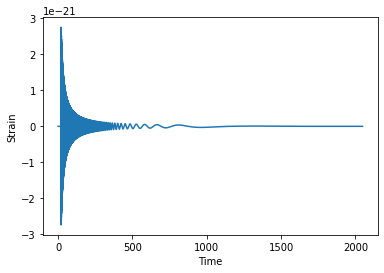

In [9]:
m = 1.38 # Solar masses
conditioned = stilde['H1']
hp, hc = get_fd_waveform(approximant="TaylorF2",
                     mass1=m,
                     mass2=m,
                     delta_f=conditioned.delta_f,
                     f_lower=20.0)

hp.resize(len(conditioned))

template = hp .cyclic_time_shift(hp.start_time)
pylab.plot(hp.sample_frequencies, template)
pylab.xlabel('Time')
pylab.ylabel('Strain')
pylab.show()

**Search for signal**

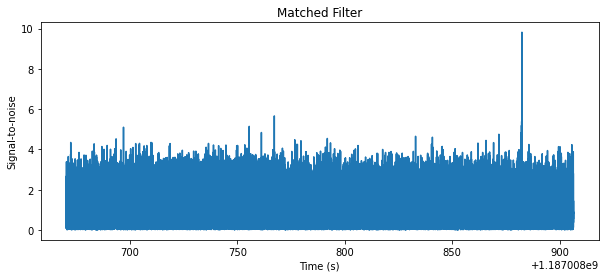

We found a signal at 1187008882.425879s with SNR 9.81930499565154


In [10]:
ifo = 'L1'                            
conditioned = stilde[ifo]
snr = matched_filter(template, conditioned,
                     psd=psds[ifo] , low_frequency_cutoff=20)

snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.title('Matched Filter')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

In [11]:
from pycbc.filter import sigma

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

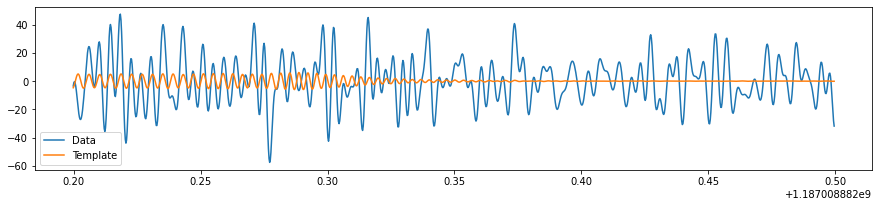

In [12]:
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(20, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

white_data = white_data.highpass_fir(20., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(20., 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

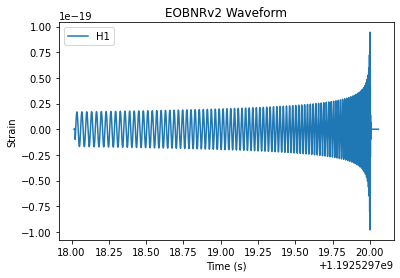

In [13]:
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector

apx = 'EOBNRv2'
# NOTE: Inclination runs from 0 to pi, with poles at 0 and pi
#       coa_phase runs from 0 to 2 pi.
hp, hc = get_td_waveform(approximant=apx,
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=30)

det_h1 = Detector('H1')

# Choose a GPS end time, sky location, and polarization phase for the merger
# NOTE: Right ascension and polarization phase runs from 0 to 2pi
#       Declination runs from pi/2. to -pi/2 with the poles at pi/2. and -pi/2.
end_time = 1192529720
declination = 0.65
right_ascension = 4.67
polarization = 2.34
hp.start_time += end_time
hc.start_time += end_time

signal_h1 = det_h1.project_wave(hp, hc,  right_ascension, declination, polarization)

pylab.plot(signal_h1.sample_times, signal_h1, label='H1')

pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.title('EOBNRv2 Waveform')
pylab.legend()
pylab.show()

In [14]:
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter import match

f_low = 30
sample_rate = 4096

mass_1 = numpy.arange(5,15,.1) #mass range between 5 to 15 Solar mass
mass_2 = mass_1

match_list = []
m_list = []
apx = 'TaylorT4'

for i in range(len(mass_1)):
 
 m_1=mass_1[i].astype(float)
 m_list.append(m_1)
 sp, sc = get_td_waveform(approximant=apx,
                         mass1=m_1,
                         mass2=m_1,
                         delta_t=1.0/4096,
                         f_lower=30)

 det_h1 = Detector('H1')

 end_time = 1192529720
 declination = 0.65
 right_ascension = 4.67
 polarization = 2.34
 sp.start_time += end_time
 sc.start_time += end_time

 signal_h1 = det_h1.project_wave(sp, sc,  right_ascension, declination, polarization)

 # Resize the waveforms to the same length
 tlen = max(len(sp), len(hp))
 sp.resize(tlen)
 hp.resize(tlen)
 # Generate the aLIGO ZDHP PSD
 delta_f = 1.0 / sp.duration
 flen = tlen//2 + 1
 psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
 m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
 match_list.append(m)

**Plot of the Matches for different Masses**

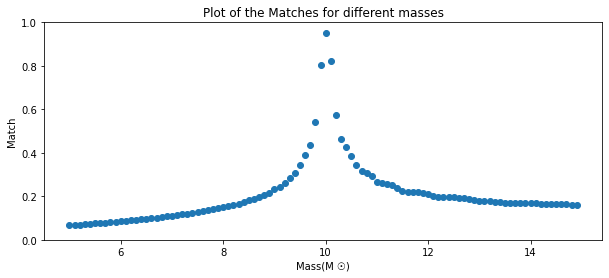

In [15]:
pylab.figure(figsize=[10, 4])
pylab.plot(m_list,match_list, label= 'H1',marker='o',linestyle='None')
pylab.ylabel('Match')
pylab.ylim(0, 1.0)
pylab.title('Plot of the Matches for different masses')
pylab.xlabel('Mass(M ☉)')
pylab.show()

# **PART 2**

**Load Data**

In [16]:
import numpy as np
d = np.load('/content/noise_ts_4096Hz.npy')
dt = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0])
data = d
#calculate power spectral density from the data
from pycbc.psd import welch, interpolate
psds = interpolate(welch(d), 1.0 / d.duration)

**Matched Filtering**

In [17]:
flow = 30 #Hz
stilde = data.to_frequencyseries()

mass_1 = numpy.arange(5,10,.1)
mass_2 = mass_1

snr_list = []
m_list = []
apx = 'TaylorF2'

for i in range(len(mass_1)):
 
 m_1=mass_1[i].astype(float)
 m_list.append(m_1)
 hp, hc = pycbc.waveform.get_fd_waveform(approximant=apx,
                             mass1=m_1,
                             mass2=m_1,
                             f_lower=flow, delta_f=stilde.delta_f)

 hp.resize(len(stilde))  
 snr = pycbc.filter.matched_filter(hp, stilde, psd=psds,
                                      low_frequency_cutoff=flow)

# Remove regions corrupted by filter wraparound
 snr = snr[len(snr) // 4: len(snr) * 3 // 4]

 #print ( 'Maximum SNR', max(abs(snr)) )
 snr_list.append(max(abs(snr)))

print("The highest SNR was {}".format(max(snr_list)))

The highest SNR was 6.54525735364218


Since the threshold on matched filter SNR is 8.0, the data does not contain a GWS, only noise.

In [18]:
white_data = (data.to_frequencyseries() / psds**0.5).to_timeseries()
#white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_data = white_data.time_slice(+4, -4)

**Calculate Mean and Standard Deviation**

In [19]:
import statistics
mu = statistics.mean(white_data)
print(mu)
sigma = statistics.stdev(white_data)  # standard deviation of distribution
print(sigma)

0.0014166022882674423
44.72975997678891


Text(0, 0.5, 'Probability')

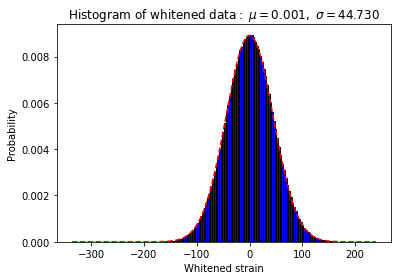

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

n, bins, patches = plt.hist(white_data, color = 'blue', edgecolor = 'black', density=True, bins = int(180))

# add 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--',color = 'red')

plt.title(r'$\mathrm{Histogram\ of\ whitened\ data:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu,sigma))
plt.xlabel('Whitened strain')
plt.ylabel('Probability')

In [21]:
hp, hc = get_fd_waveform(approximant="TaylorF2", mass1=3, mass2=3, delta_f=1.0/(200.0) ,distance = 500, f_lower=20.0, f_final = 2048.0) #Luminosity distance = 500 Mpc
psds = pycbc.psd.interpolate(pycbc.psd.welch(data),hp.delta_f)

In [22]:
from pycbc.filter import sigmasq
SNR = (pycbc.filter.sigmasq(hp, psds))**0.5
print(SNR) #SNR for the whole data strain

9.265722861103699


In [23]:
chunks = 690
data_sliced = len(data)/chunks
data_sliced = int(data_sliced)

SNR_list = []
for i in range(0,chunks):
  data_chunk = data[i*data_sliced : (i+1)*data_sliced]
  psds = pycbc.psd.interpolate(pycbc.psd.welch(data_chunk),hp.delta_f)
  SNR=(pycbc.filter.sigmasq(hp, psds))**0.5
  SNR_list.append(SNR)
print(SNR_list)

[13.743389381874236, 14.221170857331995, 16.47819854963983, 17.298415319858623, 14.82268093222983, 16.497348981098263, 14.662200544751405, 14.549854208240736, 15.243344728871206, 15.905693020879646, 13.904130350251789, 14.61683842827159, 17.295507473796754, 14.099780977103975, 19.11122559208211, 17.530961634777235, 16.962538288815654, 16.76311880923138, 16.78274414243736, 14.140234386003888, 14.40446815944923, 15.241013613383933, 17.23937037614164, 15.976028976178052, 14.355075874870401, 15.392555978078013, 15.815096781584073, 15.33443391190541, 14.759971254499739, 16.936358951974608, 14.991850866601755, 20.270914882954788, 17.896209513797146, 16.792248062371648, 15.204299378146805, 14.345430734288971, 16.135209272028614, 13.765896291933286, 17.799104430255547, 16.211627474768843, 16.515315732303442, 16.681504721190745, 14.635830807714004, 15.414078949103736, 15.623204547330067, 16.188202805535635, 15.611141114795373, 16.47507190625069, 15.432840867681028, 17.66720758858833, 18.2187477

Text(0, 0.5, 'Probability')

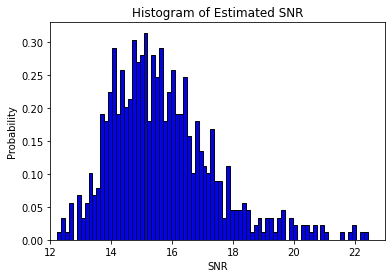

In [24]:
fig, ax = plt.subplots()

n, bins, patches = plt.hist(SNR_list, color = 'blue', density=True, edgecolor = 'black', bins = int(100))

plt.title('Histogram of Estimated SNR')
plt.xlabel('SNR')
plt.xlim(12,23)
plt.ylabel('Probability')

Above histogram was found by slicing an arbitrary gravitational waveform into chunks and compare the SNR of the individual chunks. If the noise that we were provided with was stationary Gaussian, it should show a more uniform distribution of the data chunk's SNR. As it is shown in the slides, there are a lot of sources for noise and they are not distributed stationary.
Also, the SNR of the whole data strain should be reflected similarly in the SNR of the data chunks if the noise was stationary.

# **PART 3**

**Modeled PSD for aLIGO detector**

In [25]:
flow = 4.0 # set up the lower cut off frequency
delta_f = 1.0 / 16
flen = int(2048.0/ (delta_f)) + 1
psd_ligo = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
psd_ligo.data[:int(flow/delta_f)] = np.inf #set the value outside the frequency range to infinity
psd_ligo.data[-1] = np.inf

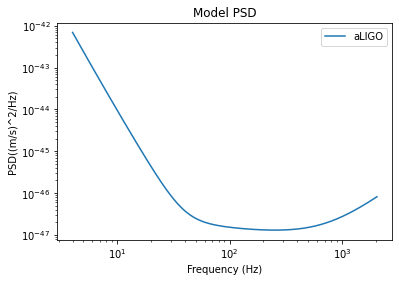

In [26]:
pylab.loglog(psd_ligo.sample_frequencies, psd_ligo)
pylab.title('Model PSD')
pylab.legend(['aLIGO'])
pylab.xlabel('Frequency (Hz)')
pylab.ylabel('PSD((m/s)^2/Hz)')
pylab.show()

**Find Horizon Distance for aLIGO detector**

In [27]:
hp, hc = get_fd_waveform(approximant="TaylorF2",
                           mass1=5, mass2=5,
                           f_lower=flow, 
                           delta_f=delta_f,
                           distance = 1000)
from pycbc.filter import sigmasq
SNR = (pycbc.filter.sigmasq(hp, psd_ligo))**0.5
print(SNR)

10.232787548086074


In [28]:
horizon_distance = 1000*(SNR/8)
hp, hc = get_fd_waveform(approximant="TaylorF2",
                           mass1=5, mass2=5,
                           f_lower=flow, 
                           delta_f=delta_f,
                           distance = horizon_distance)
from pycbc.filter import sigmasq
SNR = (pycbc.filter.sigmasq(hp, psd_ligo))**0.5
print(SNR)
print(horizon_distance)

8.0
1279.0984435107594


In [29]:
mass1 = numpy.arange(5,500,10) #mass range between 1.3 to 1.5 Solar mass
mass2 = mass1

hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
hor_distance_list = []
m_list = []
dist = 1000 #Mpc
for i in range(len(mass1)):
 
    m = mass1[i]
    m_list.append(m*2)
    hp, hc = get_fd_waveform(approximant="TaylorF2",
                           mass1=m, mass2=m,
                           f_lower=flow, 
                           delta_f=delta_f,
                           distance = dist)

    SNR = (pycbc.filter.sigmasq(hp, psd_ligo))**0.5
    hor_distance_list.append(dist*(SNR/8)/1000) #divide by 1000 to get from Mpc to Gpc
print(hor_distance_list)

[1.2790984435107593, 2.9435279033228516, 4.020940512925445, 4.613462822001341, 4.79328426926457, 4.689782598696003, 4.4426344768440895, 4.1470356539143065, 3.8424888214671564, 3.579988761695487, 3.3423143576863334, 3.113969920786549, 2.9311119170873416, 2.7588961861761874, 2.6065387641877984, 2.4636038918696843, 2.353533831513617, 2.244405057821296, 2.1389057360360066, 2.0393592751778793, 1.947781349748132, 1.8659387405760828, 1.7954097396156783, 1.7172187613784502, 1.652525872966559, 1.581603926108731, 1.5259969989968802, 1.4652986372131895, 1.4215343329842418, 1.373641727940212, 1.3217350773729002, 1.2659018745978918, 1.229369032386943, 1.1897081322631065, 1.1229433354829583, 1.1010214950557808, 1.0519281228485402, 0.9995505812833856, 0.9697303845506587, 0.9375078396730145, 0.8754674518029318, 0.8373663963925325, 0.796366662597173, 0.7521889418415606, 0.7356861576160455, 0.6853393723596716, 0.6304585598244112, 0.6063280637524335, 0.541779324758345, 0.5107348970178973]


Text(0, 0.5, 'Horizon Distance (Gpc)')

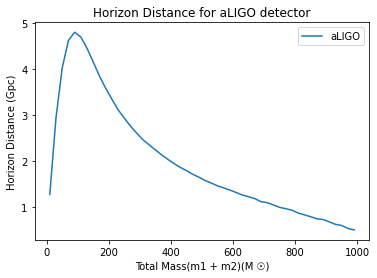

In [30]:
pylab.plot(m_list,hor_distance_list)
pylab.legend(['aLIGO'])
pylab.title('Horizon Distance for aLIGO detector')
pylab.xlabel('Total Mass(m1 + m2)(M ☉)')
pylab.ylabel('Horizon Distance (Gpc)')

**Modeled PSD for Einstein Telescope detector**

In [31]:
flow = 4.0 # set up the lower cut off frequency
delta_f = 1.0 / 16
flen = int(2048.0/ (delta_f)) + 1
psd_et = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow)
psd_et.data[:int(flow/delta_f)] = np.inf #set the value outside the frequency range to infinity
psd_et.data[-1] = np.inf

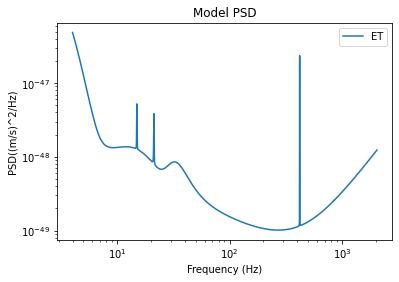

In [32]:
pylab.loglog(psd_et.sample_frequencies, psd_et, label='raw')
pylab.title('Model PSD')
pylab.legend(['ET'])
pylab.xlabel('Frequency (Hz)')
pylab.ylabel('PSD((m/s)^2/Hz)')
pylab.show()

**Find Horizon Distance for Einstein Telescope detector**

In [33]:
hp, hc = get_fd_waveform(approximant="TaylorF2",
                           mass1=5, mass2=5,
                           f_lower=flow, 
                           delta_f=delta_f,
                           distance = 1000)
from pycbc.filter import sigmasq
SNR = (pycbc.filter.sigmasq(hp, psd_et))**0.5
print(SNR)

147.18470790195317


In [34]:
horizon_distance = 1000*(SNR/8)
hp, hc = get_fd_waveform(approximant="TaylorF2",
                           mass1=5, mass2=5,
                           f_lower=flow, 
                           delta_f=delta_f,
                           distance = horizon_distance)
from pycbc.filter import sigmasq
SNR = (pycbc.filter.sigmasq(hp, psd_et))**0.5
print(SNR)
print(horizon_distance)

8.000000000000002
18398.088487744146


In [35]:
mass1 = numpy.arange(5,500,10) #mass range between 1.3 to 1.5 Solar mass
mass2 = mass1

hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
hor_distance_list = []
m_list = []
dist = 1000 #Mpc
for i in range(len(mass1)):
 
    m = mass1[i]
    m_list.append(m*2)
    hp, hc = get_fd_waveform(approximant="TaylorF2",
                           mass1=m, mass2=m,
                           f_lower=flow, 
                           delta_f=delta_f,
                           distance = dist)

    SNR = (pycbc.filter.sigmasq(hp, psd_et))**0.5
    hor_distance_list.append(dist*(SNR/8)/1000) #divide by 1000 to get from Mpc to Gpc
print(hor_distance_list)

[18.398088487744147, 43.858029185775266, 63.897891961103376, 80.91219038567445, 96.23575461842434, 110.87031877510552, 125.09624907005835, 138.45884185404879, 150.25390811446988, 160.67485034651736, 170.84352153213737, 179.9200783343585, 188.70534057831838, 196.90942418657303, 204.6353120400245, 212.31170855327173, 219.06350067657758, 224.93669411013073, 229.8755680907568, 233.8413651815007, 236.83296395953116, 238.91155037308386, 240.2267901485913, 239.58994911197163, 238.32624495745287, 234.87259295439563, 231.2610417479366, 225.48030148828593, 220.42168773828078, 213.57307068693052, 204.90462935057462, 194.5038384135788, 186.90346066252135, 178.4352492678659, 164.76727499302646, 159.58263210500988, 149.5121188214729, 139.17239404645983, 133.131519788236, 126.88849674732876, 115.99022688400636, 109.40303452716938, 102.64988370134293, 95.72803408812315, 93.06807710252744, 85.73057522539487, 78.06317559540906, 74.72059514938324, 66.18585710259813, 62.14475275978338]


Text(0, 0.5, 'Horizon Distance (Gpc)')

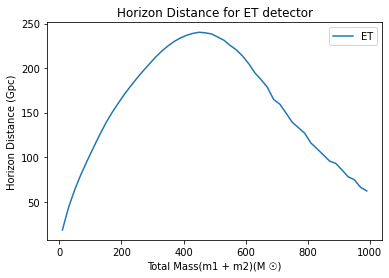

In [36]:
pylab.plot(m_list,hor_distance_list)
pylab.legend(['ET'])
pylab.title('Horizon Distance for ET detector')
pylab.xlabel('Total Mass(m1 + m2)(M ☉)')
pylab.ylabel('Horizon Distance (Gpc)')

The aLIGO detector shows better low frequency detection performance in comparison to the ET detector and has a higher sensitivity. 